## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgbm
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR


colors_palette = ['#ffa600','#ff6361','#bc5090','#58508d', '#65345a']
np.random.seed(1234)

## 2. Load data 📊

In [2]:
df_train = pd.read_csv("../../data/train/protein/protein_maccs_train.csv")
df_test = pd.read_csv("../../data/train/protein/protein_maccs_test.csv")
df_valid = pd.read_csv("../../data/train/protein/protein_maccs_valid.csv")

In [3]:
df_train_all = pd.concat([df_train, df_valid])

In [5]:
X_train = df_train_all.loc[:, df_train_all.columns != 'protein_plasma_binding']
y_train = df_train_all['protein_plasma_binding']

X_test = df_test.loc[:, df_test.columns != 'protein_plasma_binding']
y_test = df_test['protein_plasma_binding']

In [6]:
X_train.shape, y_train.shape

((2130, 166), (2130,))

In [7]:
X_test.shape, y_test.shape

((533, 166), (533,))

## 3. Metrics 📏

In [9]:
def print_evaluate(true, predicted):  
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, mse, rmse, r2_square

# 4. Models ⚙️

## 4.1. Ridge Regression

Poor results.

In [10]:
# default: 'alpha': 1.0, 'solver': 'auto', 'random_state': None, 
params = {
    'alpha': [1, 20, 50, 100],
    'solver': ['cholesky', 'svd','lsqr'],
    'tol': [0.001, 0.0001],
}

grid = GridSearchCV(Ridge(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

ridge = Ridge(alpha=100, solver='cholesky', tol=0.0001)
ridge.fit(X_train, y_train)

ridge_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, ridge_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, ridge.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, ridge_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, ridge.predict(X_train))

Best params:  {'alpha': 20, 'solver': 'lsqr', 'tol': 0.0001} 

Test set:
Tuned model:
MAE: 13.04279911568381
MSE: 346.0961682161865
RMSE: 18.6036600758073
R2 Square 0.2500333167073856 

Base model:
MAE: 13.17645404126811
MSE: 358.3644981145027
RMSE: 18.93051763989835
R2 Square 0.22344868639841164 

Train set:
Tuned model:
MAE: 13.068719161149591
MSE: 364.0215025032323
RMSE: 19.07934753871925
R2 Square 0.29649919332324826 

Base model:
MAE: 13.247981555164024
MSE: 386.97012792615453
RMSE: 19.671556316828482
R2 Square 0.2521491305216558 



In [11]:
results_df = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, ridge_tuned.predict(X_test))]],                           columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square'])
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,13.042799,346.096168,18.60366,0.250033


## 4.2. Random Forest Regressor

Better results - first model.

'max_depth': None --> overfitting

In [17]:
# default: 'n_estimators': 100, 'max_depth': None
params = {
    'max_depth': [5, 10, 12, 13],
    'n_estimators': [500, 1000, 1500, 2000],
}


grid = GridSearchCV(RandomForestRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train) 

rf_reg = RandomForestRegressor(random_state=0, max_depth=13)
rf_reg.fit(X_train, y_train)

rf_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, rf_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, rf_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, rf_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, rf_reg.predict(X_train))

Best params:  {'max_depth': 13, 'n_estimators': 2000} 

Test set:
Tuned model:
MAE: 9.615511165604547
MSE: 222.80527908103338
RMSE: 14.926663360611888
R2 Square 0.5171962260266567 

Base model:
MAE: 9.622907638347321
MSE: 225.91561105837863
RMSE: 15.030489381865737
R2 Square 0.510456349740215 

Train set:
Tuned model:
MAE: 4.39675575617257
MSE: 45.725365204125744
RMSE: 6.762053327512712
R2 Square 0.9116320572123183 

Base model:
MAE: 4.443184942161657
MSE: 47.18901838165327
RMSE: 6.869426350260499
R2 Square 0.9088034298262851 



In [18]:
params = {'max_depth': 13, 'n_estimators': 2000} 

rf_best = RandomForestRegressor(random_state=0, **params)
rf_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, rf_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, rf_best.predict(X_train))

Test set:
MAE: 9.615511165604547
MSE: 222.80527908103338
RMSE: 14.926663360611888
R2 Square 0.5171962260266567 

Train set:
MAE: 4.39675575617257
MSE: 45.725365204125744
RMSE: 6.762053327512712
R2 Square 0.9116320572123183 



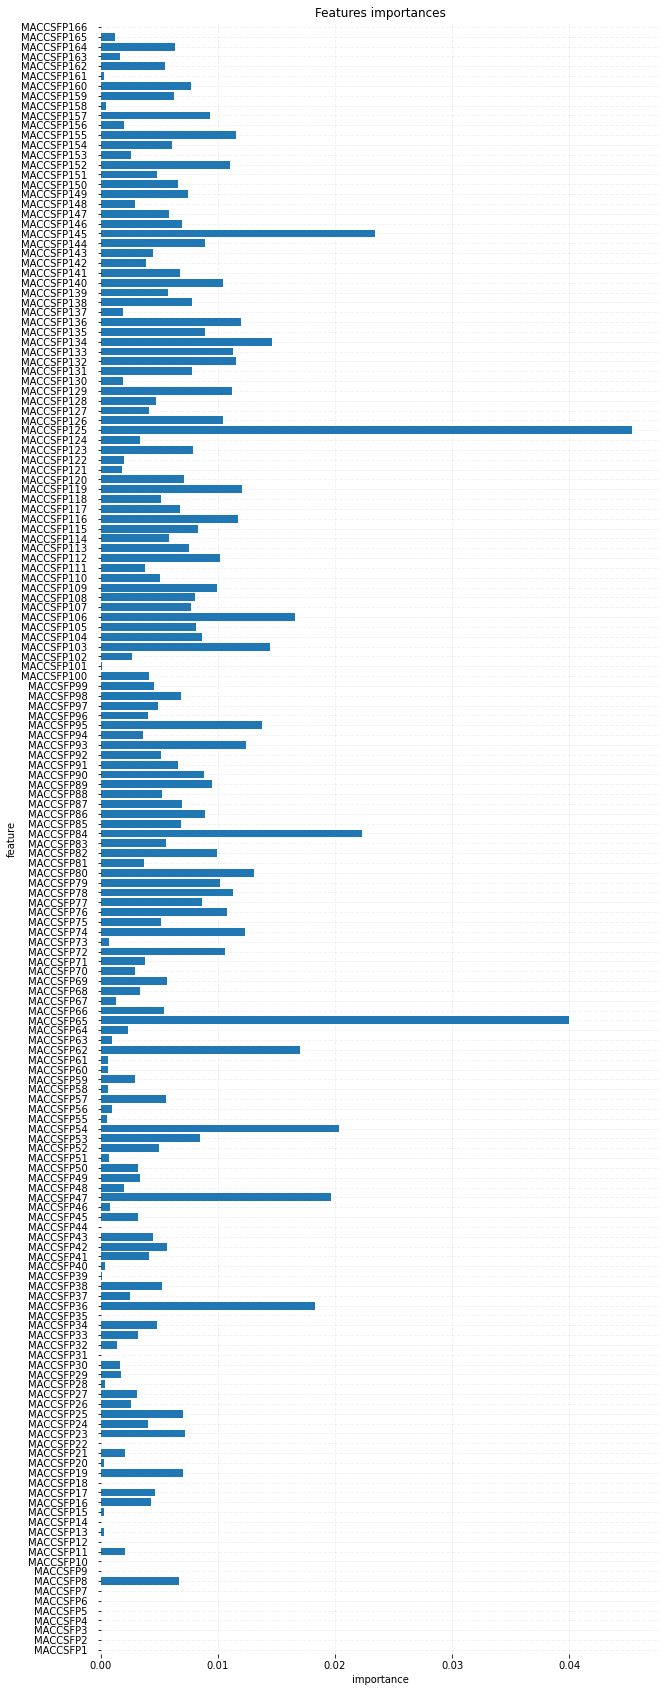

In [19]:
fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(list(X_train.columns), rf_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [20]:
results_df = results_df.append(pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, rf_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,13.042799,346.096168,18.603660,0.250033
1,Random Forest Regressor,9.615511,222.805279,14.926663,0.517196


## 4.3. XGBoost

Better results - second model.

'max_depth': None --> overfitting

In [43]:
# default: 'booster': gbtree, 'eta': 0.3, 'gamma': 0, 'max_depth': 6 

params = {
    'eta': [0.001, 0.005, 0.01],
    'lambda': [0.6, 0.8],
    'gamma': [0.1, 0.5, 0.8],
    'max_depth': [5, 10, 15],
    'n_estimators': [500, 1000, 3000, 4000],
    'min_child_weight': [95, 125, 155, 185],
    'colsample_bytree': [0.2],
    'subsample': [0.9]   
}


grid = GridSearchCV(xgb.XGBRegressor(verbosity=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

xgbr = xgb.XGBRegressor(verbosity=0, max_depth=5) 
xgbr.fit(X_train, y_train)

xgbr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, xgbr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, xgbr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, xgbr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, xgbr.predict(X_train))


Best params:  {'colsample_bytree': 0.2, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 'min_child_weight': 95, 'n_estimators': 4000, 'subsample': 0.9} 

Test set:
Tuned model:
MAE: 9.981162648603572
MSE: 211.50136429855047
RMSE: 14.543086477723719
R2 Square 0.5416910348577837 

Base model:
MAE: 9.100403734031808
MSE: 217.96561577443265
RMSE: 14.763658617511876
R2 Square 0.5276834448161959 

Train set:
Tuned model:
MAE: 7.465733381389451
MSE: 125.16891058131625
RMSE: 11.187891248189548
R2 Square 0.7581010216174681 

Base model:
MAE: 3.5782470427628414
MSE: 33.28475835798598
RMSE: 5.769294441956137
R2 Square 0.9356745296806307 



In [44]:
params = {'colsample_bytree': 0.2, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 
          'min_child_weight': 95, 'n_estimators': 4000, 'subsample': 0.9} 

xgbr_best = xgb.XGBRegressor(**params) 
xgbr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, xgbr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, xgbr_best.predict(X_train))

Test set:
MAE: 9.981162648603572
MSE: 211.50136429855047
RMSE: 14.543086477723719
R2 Square 0.5416910348577837 

Train set:
MAE: 7.465733381389451
MSE: 125.16891058131625
RMSE: 11.187891248189548
R2 Square 0.7581010216174681 



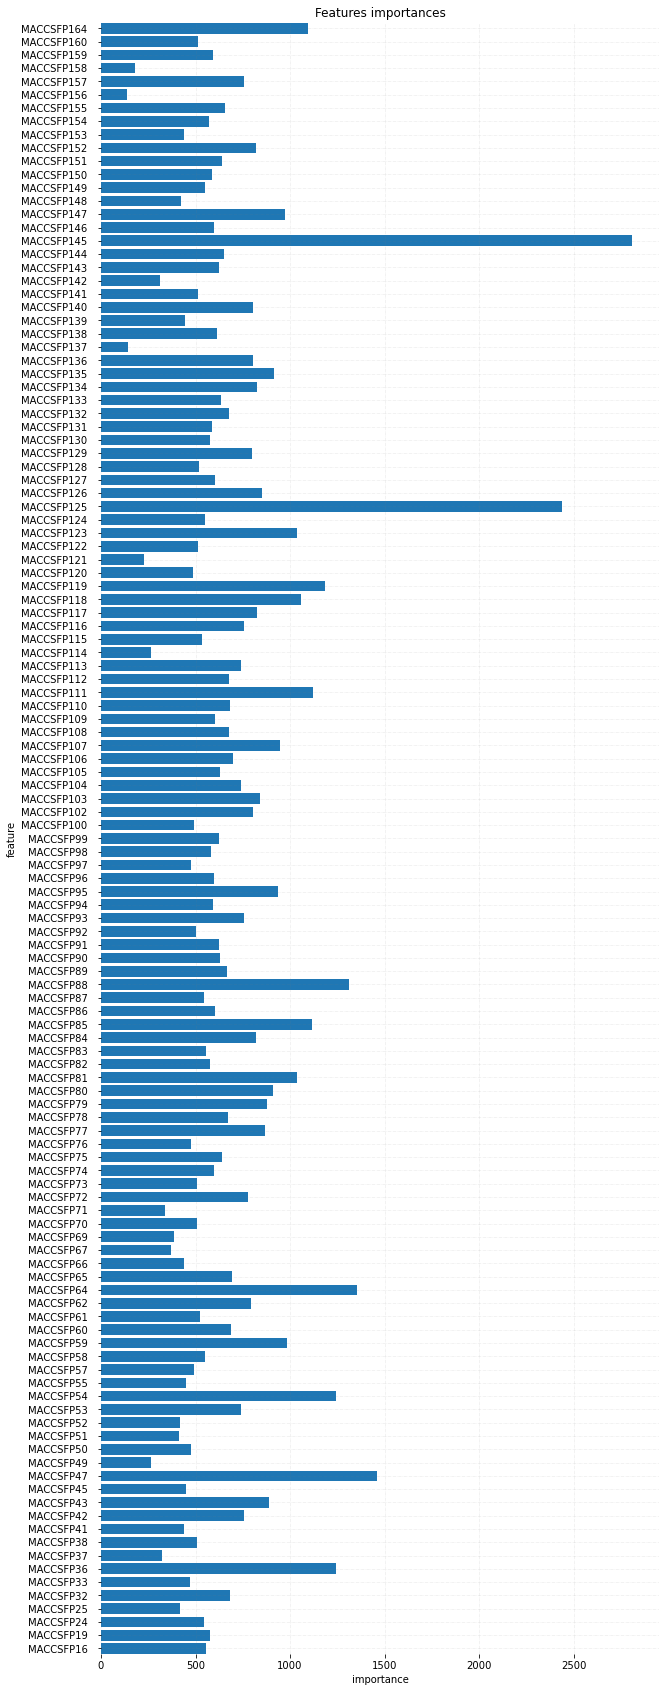

In [45]:
feature_importance = xgbr_best.get_booster().get_score(importance_type='gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(keys, values)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [46]:
results_df = results_df.append(pd.DataFrame(data=[["XGBoost", *evaluate(y_test, xgbr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,13.042799,346.096168,18.603660,0.250033
1,Random Forest Regressor,9.615511,222.805279,14.926663,0.517196
2,XGBoost,9.981163,211.501364,14.543086,0.541691


## 4.4. LightGBM

Better results - third model.

In [62]:
# default: 'n_estimators': 100, 'num_leaves': 31, 'learning_rate': 0.1, 'max_depth': -1 

params = {
    'num_leaves': [50, 60, 70, 80],
    'learning_rate': [0.001, 0.005, 0.01],
    'max_depth': [5, 10, 15],
    'n_estimators': [1000, 2000, 3000, 4000, 5000],
    'min_child_samples': [40, 50],
    'reg_alpha': [1.7, 2.7, 3.7],
    'reg_lambda': [0.04, 0.06],
    'colsample_bytree': [0.25],
    'subsample': [0.8],
    'cat_smooth': [28],
}

grid = GridSearchCV(lgbm.LGBMRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

lgbm_reg = lgbm.LGBMRegressor(random_state=0)
lgbm_reg.fit(X_train,y_train)

lgbm_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, lgbm_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, lgbm_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, lgbm_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, lgbm_reg.predict(X_train))

Best params:  {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_samples': 40, 'n_estimators': 3000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.06, 'subsample': 0.8} 

Test set:
Tuned model:
MAE: 9.004784382383038
MSE: 186.26776061495076
RMSE: 13.647994747029717
R2 Square 0.5963705251267676 

Base model:
MAE: 8.919853919167826
MSE: 201.22571827439052
RMSE: 14.18540511491972
R2 Square 0.5639576557428044 

Train set:
Tuned model:
MAE: 4.947689165002903
MSE: 59.49566050111995
RMSE: 7.713343017208554
R2 Square 0.8850198549577922 

Base model:
MAE: 5.384483706281476
MSE: 71.23410803774787
RMSE: 8.440030096969316
R2 Square 0.8623343617812534 



In [63]:
params = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 50, 'n_estimators': 2000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.04, 
          'subsample': 0.8}

lgbm_best = lgbm.LGBMRegressor(**params) 
lgbm_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, lgbm_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, lgbm_best.predict(X_train))

Test set:
MAE: 9.33955237049501
MSE: 197.57663453896922
RMSE: 14.056195592654836
R2 Square 0.5718649701757151 

Train set:
MAE: 6.453960401972529
MSE: 98.42215162916328
RMSE: 9.92079390115344
R2 Square 0.8097912826856619 



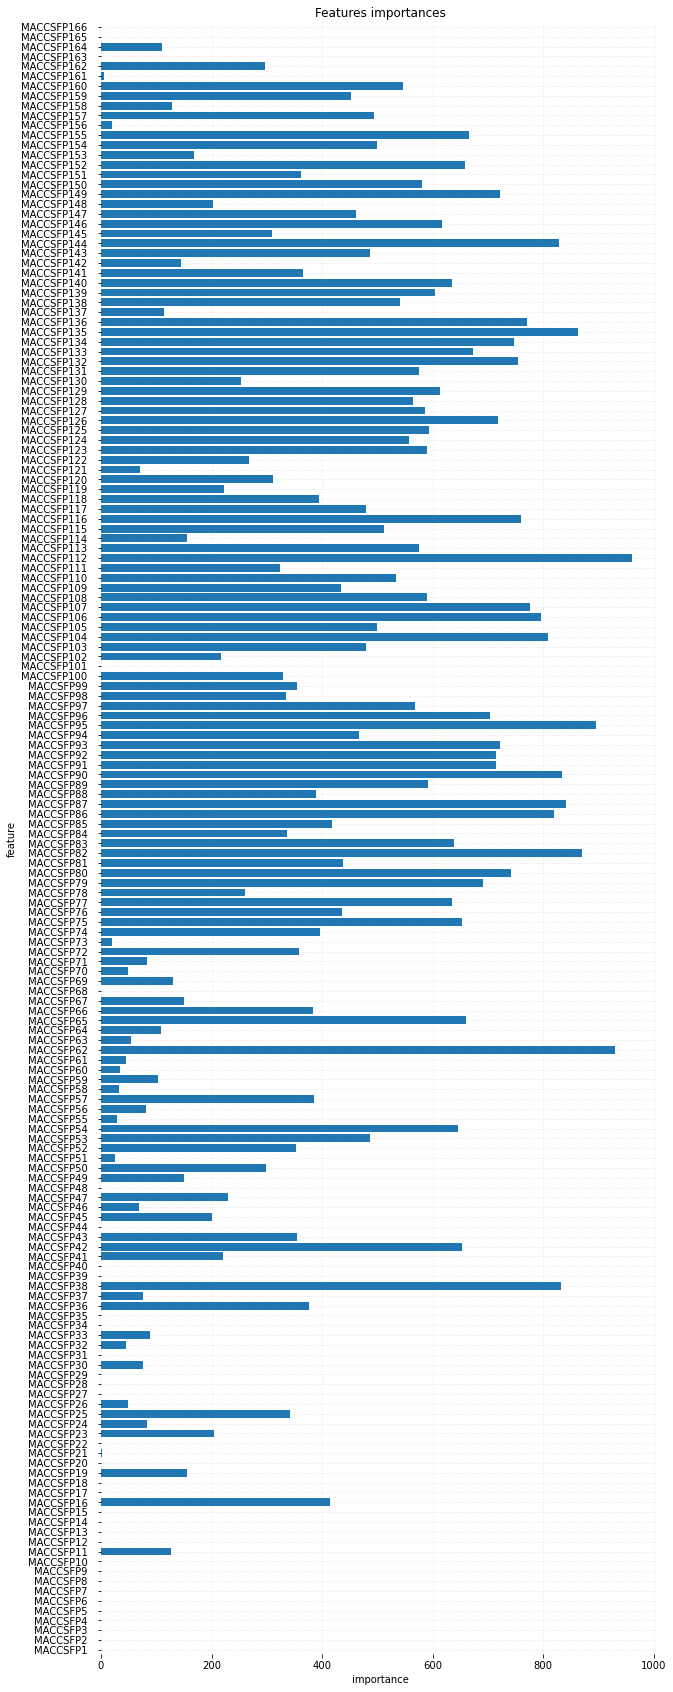

In [64]:
fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(list(X_train.columns), lgbm_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [65]:
results_df = results_df.append(pd.DataFrame(data=[["LightGBM", *evaluate(y_test, lgbm_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,13.042799,346.096168,18.603660,0.250033
1,Random Forest Regressor,9.615511,222.805279,14.926663,0.517196
2,XGBoost,9.981163,211.501364,14.543086,0.541691
3,LightGBM,9.339552,197.576635,14.056196,0.571865


## 4.5. Histogram-based Gradient Boosting Regressor (Regression Tree)

Better results - fourth model.

In [88]:
# default: 'learning_rate': 0.1, 'max_depth': None , 'l2_regularization': 0

params = {
    'learning_rate': [0.005, 0.1, 0.15],
    'max_depth': [5, 10, 15, 20],
    'l2_regularization': [0, 0.1, 0.15],
    'min_samples_leaf':[10, 15, 20],
}

grid = GridSearchCV(HistGradientBoostingRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

hist_reg = HistGradientBoostingRegressor(random_state=0)
hist_reg.fit(X_train,y_train)

hist_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, hist_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, hist_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, hist_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, hist_reg.predict(X_train))

Best params:  {'l2_regularization': 0, 'learning_rate': 0.1, 'max_depth': 20, 'min_samples_leaf': 20} 

Test set:
Tuned model:
MAE: 8.919853929276906
MSE: 201.225718040352
RMSE: 14.185405106670448
R2 Square 0.5639576562499499 

Base model:
MAE: 8.919853929276906
MSE: 201.225718040352
RMSE: 14.185405106670448
R2 Square 0.5639576562499499 

Train set:
Tuned model:
MAE: 5.3844836994022325
MSE: 71.23410790122502
RMSE: 8.440030088881498
R2 Square 0.8623343620450948 

Base model:
MAE: 5.3844836994022325
MSE: 71.23410790122502
RMSE: 8.440030088881498
R2 Square 0.8623343620450948 



In [89]:
params = {'l2_regularization': 0, 'learning_rate': 0.1, 'max_depth': 20, 'min_samples_leaf': 15} 

hist_best = HistGradientBoostingRegressor(random_state=0, **params) 
hist_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, hist_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, hist_best.predict(X_train))

Test set:
MAE: 8.782587715683409
MSE: 191.08595794886472
RMSE: 13.823384460719621
R2 Square 0.5859298216292714 

Train set:
MAE: 5.042257039975152
MSE: 64.0580809909798
RMSE: 8.00362923872538
R2 Square 0.8762026107210004 



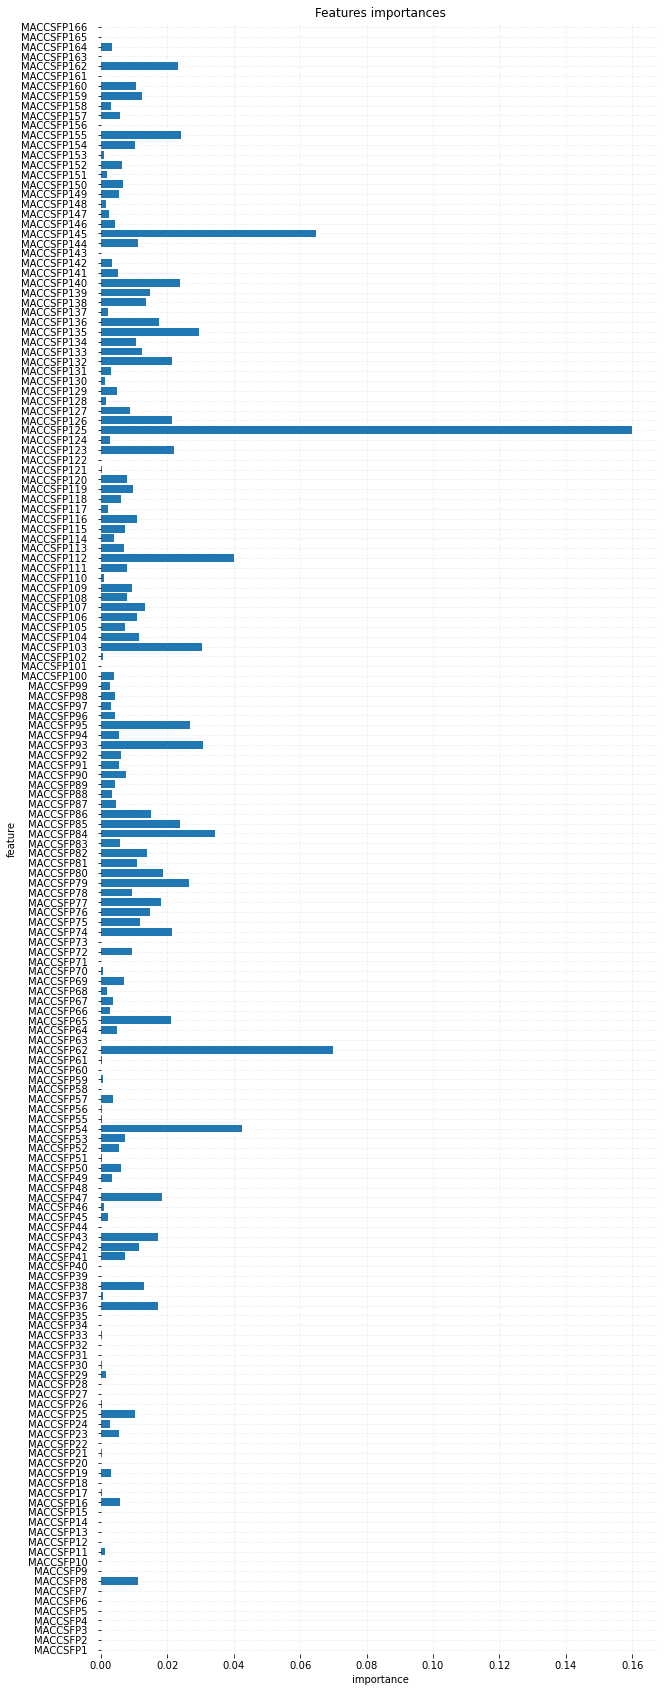

In [90]:
feature_importance = permutation_importance(hist_best, X_train, y_train, n_repeats=15, random_state=0)
fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [91]:
results_df = results_df.append(pd.DataFrame(data=[["HistGradient Boosting Regressor", *evaluate(y_test, hist_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,13.042799,346.096168,18.603660,0.250033
1,Random Forest Regressor,9.615511,222.805279,14.926663,0.517196
2,XGBoost,9.981163,211.501364,14.543086,0.541691
3,LightGBM,9.339552,197.576635,14.056196,0.571865
4,HistGradient Boosting Regressor,8.782588,191.085958,13.823384,0.585930


## 4.6. Support Vector Regression

Better results - fifth model.

In [114]:
# default: 'kernel': 'rbf', 'gamma': 'scale', 'C': 1.0, 'epsilon': 0.1
params = {
    'kernel': ['rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'C': [5.0, 15.0, 29.0],
    'epsilon': [0.1, 0.8, 2.8, 3.8],
}

grid = GridSearchCV(SVR(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

svr = SVR()
svr.fit(X_train,y_train)

svr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, svr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, svr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, svr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, svr.predict(X_train))

Best params:  {'C': 29.0, 'epsilon': 3.8, 'gamma': 'scale', 'kernel': 'rbf'} 

Test set:
Tuned model:
MAE: 9.560846641172308
MSE: 252.0570896878983
RMSE: 15.876305920707697
R2 Square 0.45380955666766265 

Base model:
MAE: 10.912824841595203
MSE: 489.515002658408
RMSE: 22.12498593577876
R2 Square -0.06074547099979055 

Train set:
Tuned model:
MAE: 7.575331314569162
MSE: 204.7951793643
RMSE: 14.310666628927528
R2 Square 0.6042168583571081 

Base model:
MAE: 11.27916982415301
MSE: 541.4055711603962
RMSE: 23.268123498907173
R2 Square -0.046309774097051504 



In [115]:
params = {'C': 29.0, 'epsilon': 3.8, 'gamma': 'scale', 'kernel': 'rbf'} 

svr_best = SVR(**params) 
svr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, svr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, svr_best.predict(X_train))

Test set:
MAE: 9.560846641172308
MSE: 252.0570896878983
RMSE: 15.876305920707697
R2 Square 0.45380955666766265 

Train set:
MAE: 7.575331314569162
MSE: 204.7951793643
RMSE: 14.310666628927528
R2 Square 0.6042168583571081 



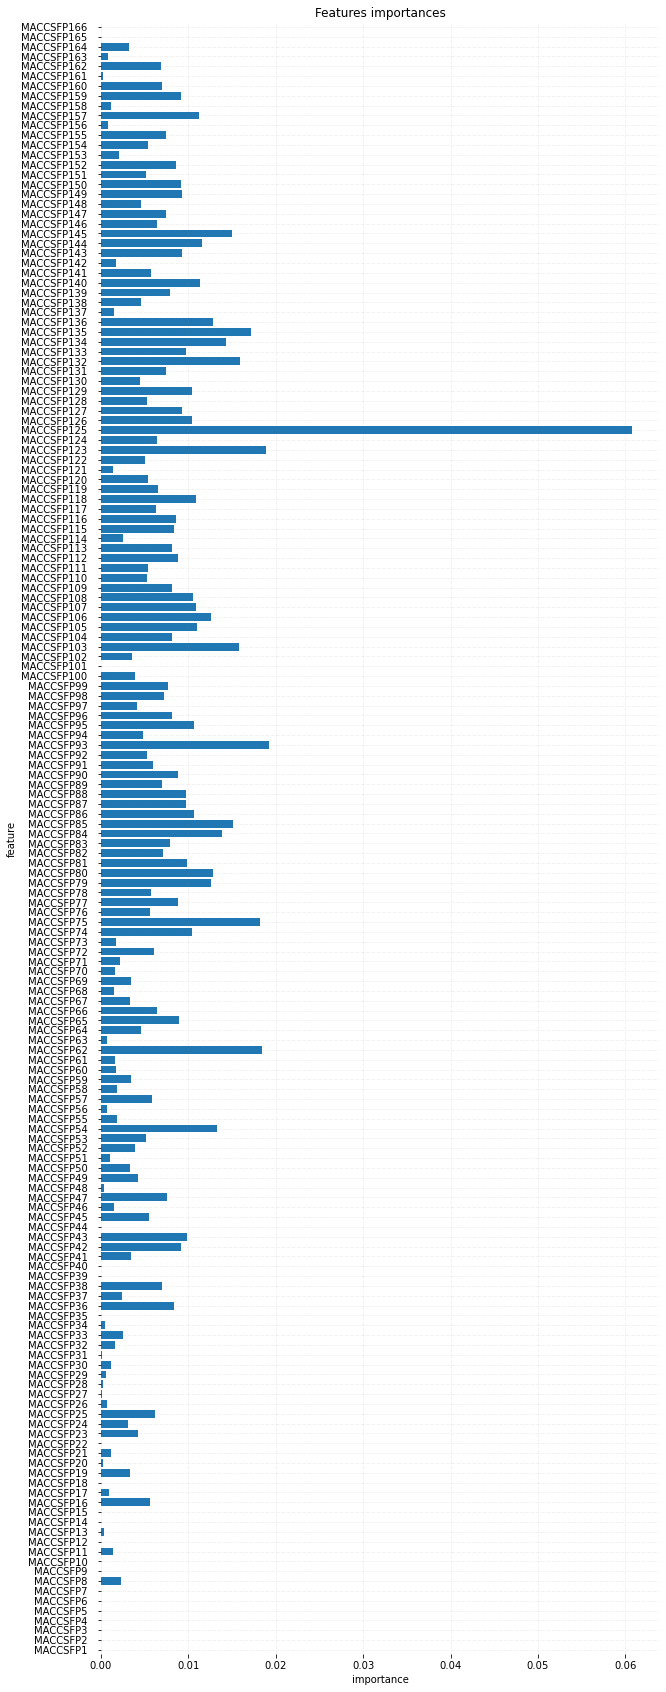

In [116]:
feature_importance = permutation_importance(svr_best, X_train, y_train, n_repeats=5, random_state=0)
fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [117]:
results_df = results_df.append(pd.DataFrame(data=[["Support Vector Regression", *evaluate(y_test, svr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,13.042799,346.096168,18.603660,0.250033
1,Random Forest Regressor,9.615511,222.805279,14.926663,0.517196
2,XGBoost,9.981163,211.501364,14.543086,0.541691
3,LightGBM,9.339552,197.576635,14.056196,0.571865
4,HistGradient Boosting Regressor,8.782588,191.085958,13.823384,0.585930
5,Support Vector Regression,9.560847,252.057090,15.876306,0.453810


### Save models

In [118]:
'''
pickle.dump(rf_best, open('models/rf.pkl', 'wb'))
pickle.dump(xgbr_best, open('models/xgb.pkl', 'wb'))
pickle.dump(lgbm_best, open('models/lgbm.pkl', 'wb'))
pickle.dump(hist_best, open('models/hist.pkl', 'wb'))
pickle.dump(svr_best, open('models/svr.pkl', 'wb'))
'''

"\npickle.dump(rf_best, open('models/rf.pkl', 'wb'))\npickle.dump(xgbr_best, open('models/xgb.pkl', 'wb'))\npickle.dump(lgbm_best, open('models/lgbm.pkl', 'wb'))\npickle.dump(hist_best, open('models/hist.pkl', 'wb'))\npickle.dump(svr_best, open('models/svr.pkl', 'wb'))\n"

## 4.7. Stacking models

### Averaging base models

In [119]:
def average_predictions(X):
    return ((0.15 * rf_best.predict(X)) + \
            (0.20 * xgbr_best.predict(X)) + \
            (0.25 * lgbm_best.predict(X)) + \
            (0.25 * hist_best.predict(X)) + \
            (0.15 * svr_best.predict(X)))

print('Test set:')
print_evaluate(y_test, average_predictions(X_test))
print('Train set:')
print_evaluate(y_train, average_predictions(X_train))

Test set:
MAE: 9.071090782403918
MSE: 197.04652329055853
RMSE: 14.037326073385861
R2 Square 0.5730136849297551 

Train set:
MAE: 5.895581314557613
MSE: 89.37032079812079
RMSE: 9.453587720972434
R2 Square 0.827284673179767 



In [120]:
results_df = results_df.append(pd.DataFrame(data=[["Averaging base models", *evaluate(y_test, average_predictions(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,13.042799,346.096168,18.603660,0.250033
1,Random Forest Regressor,9.615511,222.805279,14.926663,0.517196
2,XGBoost,9.981163,211.501364,14.543086,0.541691
3,LightGBM,9.339552,197.576635,14.056196,0.571865
4,HistGradient Boosting Regressor,8.782588,191.085958,13.823384,0.585930
5,Support Vector Regression,9.560847,252.057090,15.876306,0.453810
6,Averaging base models,9.071091,197.046523,14.037326,0.573014


### Averaging base models with Meta-model

In [121]:
meta_train = pd.DataFrame(data={
    "rf": rf_best.predict(X_train).tolist(),
    "xgbr": xgbr_best.predict(X_train).tolist(),
    "lgbm": lgbm_best.predict(X_train).tolist(),
    "hist_reg": hist_best.predict(X_train).tolist(),
    "svr_reg": svr_best.predict(X_train).tolist()
    })

    
meta_test = pd.DataFrame(data={
    "rf": rf_best.predict(X_test).tolist(),
    "xgbr": xgbr_best.predict(X_test).tolist(),
    "lgbm": lgbm_best.predict(X_test).tolist(),
    "hist_reg": hist_best.predict(X_test).tolist(),
    "svr_reg": svr_best.predict(X_test).tolist()
    })


In [122]:
meta_train

,rf,xgbr,lgbm,hist_reg,svr_reg
0,88.606319,84.601212,84.365592,87.304261,86.199930
1,93.543457,94.916962,98.068352,98.532987,95.929145
2,97.818328,102.649208,103.221222,102.556458,102.056908
3,92.295740,97.081970,95.816807,99.898020,94.199718
4,94.863969,98.147606,95.597875,93.992437,95.493467
...,...,...,...,...,...
2125,97.717279,96.809692,95.804034,96.826520,95.999803
2126,92.295635,91.247009,91.405217,94.338642,92.836266
2127,96.210265,97.159897,97.114450,99.096043,96.200246
2128,66.510166,70.348770,70.192751,68.091977,72.410685


In [130]:
params = {'alpha': 0.1} 

meta_model = Ridge(**params)
meta_model.fit(meta_train, y_train)

print('Test set:')
print_evaluate(y_test, meta_model.predict(meta_test))

print('Train set:')
print_evaluate(y_train, meta_model.predict(meta_train))

Test set:
MAE: 9.718444734810777
MSE: 247.4358326906364
RMSE: 15.730093219388003
R2 Square 0.46382350394925875 

Train set:
MAE: 3.505981556982145
MSE: 28.788117668584423
RMSE: 5.365455960921161
R2 Square 0.9443646491669141 



In [131]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model", *evaluate(y_test, meta_model.predict(meta_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,13.042799,346.096168,18.603660,0.250033
1,Random Forest Regressor,9.615511,222.805279,14.926663,0.517196
2,XGBoost,9.981163,211.501364,14.543086,0.541691
3,LightGBM,9.339552,197.576635,14.056196,0.571865
4,HistGradient Boosting Regressor,8.782588,191.085958,13.823384,0.585930
5,Support Vector Regression,9.560847,252.057090,15.876306,0.453810
6,Averaging base models,9.071091,197.046523,14.037326,0.573014
7,Base models + Meta-model,9.718445,247.435833,15.730093,0.463824


### Averaging base models with Meta-model and k-fold cross validation

![Stacked](images/stacked.png)

In [134]:
params_rf = {'max_depth': 13, 'n_estimators': 2000} 

params_xgb = {'colsample_bytree': 0.2, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 
          'min_child_weight': 95, 'n_estimators': 4000, 'subsample': 0.9} 

params_lgbm = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 50, 'n_estimators': 2000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.04, 
          'subsample': 0.8}

params_hist =  {'l2_regularization': 0, 'learning_rate': 0.1, 'max_depth': 20, 'min_samples_leaf': 15} 

params_svr = {'C': 29.0, 'epsilon': 3.8, 'gamma': 'scale', 'kernel': 'rbf'} 

In [136]:
pred1 = np.zeros(X_train.shape[0])
pred2 = np.zeros(X_train.shape[0])
pred3 = np.zeros(X_train.shape[0])
pred4 = np.zeros(X_train.shape[0])
pred5 = np.zeros(X_train.shape[0])
models1 = []
models2 = []
models3 = []
models4 = []
models5 = []

kf = KFold(n_splits=6,random_state=48,shuffle=True)
n_fold = 0

for trn_idx, test_idx in kf.split(X_train, y_train):
    print(f"-------------- fold {n_fold+1} --------------")
    X_tr,X_val = X_train.iloc[trn_idx],X_train.iloc[test_idx]
    y_tr,y_val = y_train.iloc[trn_idx],y_train.iloc[test_idx]
     
    model1 = RandomForestRegressor(**params_rf)
    model1.fit(X_tr,y_tr)
    models1.append(model1)
    #pickle.dump(model1, open('models/stacked/m1{}.pkl'.format(n_fold+1), 'wb'))
    pred1[test_idx] = model1.predict(X_val)
    mse1 = mean_squared_error(y_val, pred1[test_idx])
    r21 = r2_score(y_val, pred1[test_idx])
    print("Model1 MSE: {}".format(mse1))
    print("Model1 R2: {}".format(r21))

    model2 = xgb.XGBRegressor(**params_xgb)
    model2.fit(X_tr,y_tr)
    models2.append(model2)
    #pickle.dump(model2, open('models/stacked/m2{}.pkl'.format(n_fold+1), 'wb'))
    pred2[test_idx] = model2.predict(X_val)
    mse2 = mean_squared_error(y_val, pred2[test_idx])
    r22 = r2_score(y_val, pred2[test_idx])
    print("Model2 MSE: {}".format(mse2))
    print("Model2 R2: {}".format(r22))
    
    model3 = lgbm.LGBMRegressor(**params_lgbm)
    model3.fit(X_tr,y_tr)
    models3.append(model3)
    #pickle.dump(model3, open('models/stacked/m3{}.pkl'.format(n_fold+1), 'wb'))
    pred3[test_idx] = model3.predict(X_val)
    mse3 = mean_squared_error(y_val, pred3[test_idx])
    r23 = r2_score(y_val, pred3[test_idx])
    print("Model3 MSE: {}".format(mse3))
    print("Model3 R2: {}".format(r23))
    
    model4 = HistGradientBoostingRegressor(**params_hist)
    model4.fit(X_tr,y_tr)
    models4.append(model4)
    #pickle.dump(model4, open('models/stacked/m4{}.pkl'.format(n_fold+1), 'wb'))
    pred4[test_idx] = model4.predict(X_val)
    mse4 = mean_squared_error(y_val, pred4[test_idx])
    r24 = r2_score(y_val, pred4[test_idx])
    print("Model4 MSE: {}".format(mse4))
    print("Model4 R2: {}".format(r24))
    
    model5 = SVR(**params_svr)
    model5.fit(X_tr,y_tr)
    models5.append(model5)
    #pickle.dump(model5, open('models/stacked/m5{}.pkl'.format(n_fold+1), 'wb'))
    pred5[test_idx] = model5.predict(X_val)
    mse5 = mean_squared_error(y_val, pred5[test_idx])
    r25 = r2_score(y_val, model5.predict(X_val))
    print("Model5 MSE: {}".format(mse5))
    print("Model5 R2: {}".format(r25))
    
        
    print("Average MSE = {}".format((mse1+mse2+mse3+mse4+mse5)/5))
    print("Average R2 = {}".format((r21+r22+r23+r24+r25)/5))

    n_fold+=1

-------------- fold 1 --------------
Model1 MSE: 298.4614292366156
Model1 R2: 0.40815311251712916
Model2 MSE: 290.75838327291
Model2 R2: 0.42342819777493745
Model3 MSE: 273.1781858813073
Model3 R2: 0.45828960393441076
Model4 MSE: 272.1559881927002
Model4 R2: 0.46031661466722706
Model5 MSE: 324.87098115695153
Model5 R2: 0.3557831592409336
Average MSE = 291.88499354809693
Average R2 = 0.4211941376269276
-------------- fold 2 --------------
Model1 MSE: 234.0164331323549
Model1 R2: 0.565056931695709
Model2 MSE: 261.60518248289475
Model2 R2: 0.5137804673355539
Model3 MSE: 244.4970557377758
Model3 R2: 0.5455776408923879
Model4 MSE: 232.22914461278623
Model4 R2: 0.5683787870980882
Model5 MSE: 318.5546873453241
Model5 R2: 0.407934087012058
Average MSE = 258.18050066222713
Average R2 = 0.5201455828067594
-------------- fold 3 --------------
Model1 MSE: 271.16334637189124
Model1 R2: 0.513059695936842
Model2 MSE: 284.7014094163773
Model2 R2: 0.4887487828893712
Model3 MSE: 280.17498398613066
Model

In [137]:
test1 = np.zeros(X_test.shape[0])
test2 = np.zeros(X_test.shape[0])
test3 = np.zeros(X_test.shape[0])
test4 = np.zeros(X_test.shape[0])
test5 = np.zeros(X_test.shape[0])

n_splits = kf.n_splits

for model_id in range(n_splits):
    test1 += models1[model_id].predict(X_test)/n_splits
    test2 += models2[model_id].predict(X_test)/n_splits
    test3 += models3[model_id].predict(X_test)/n_splits
    test4 += models4[model_id].predict(X_test)/n_splits
    test5 += models5[model_id].predict(X_test)/n_splits

In [138]:
meta_train2 = pd.DataFrame(data={
    "rf": pred1.tolist(),
    "xgbr": pred2.tolist(),
    "lgbm": pred3.tolist(),
    "hist_reg": pred4.tolist(),
    "svr_reg": pred5.tolist(),
    })
meta_test2 = pd.DataFrame(data={
    "rf": test1.tolist(),
    "xgbr": test2.tolist(),
    "lgbm": test3.tolist(),
    "hist_reg": test4.tolist(),
    "svr_reg": test5.tolist()
    })

In [139]:
meta_train2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,86.572529,78.161568,73.895105,80.848257,83.363725
1,84.726114,93.180054,97.899286,98.124148,96.586107
2,93.936021,99.208397,99.345454,101.499926,101.186165
3,84.393644,100.666588,96.420852,85.757317,91.294781
4,92.766560,97.839165,94.026191,92.206003,95.376748
...,...,...,...,...,...
2125,96.814045,100.232391,97.592511,95.344751,96.605978
2126,86.741801,91.019035,91.973255,88.578242,91.610214
2127,90.554851,90.979195,92.918048,96.536286,94.262730
2128,73.014778,75.705849,75.537606,73.692309,78.902112


In [140]:
meta_test2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,91.980319,85.414454,85.778502,85.366281,87.401404
1,92.151367,87.800202,91.129955,93.615517,92.332726
2,83.668571,81.298347,84.276783,87.944069,89.623269
3,95.683702,98.631058,98.889941,97.391946,97.137462
4,81.980873,80.761416,79.526703,80.168211,84.278254
...,...,...,...,...,...
528,91.662540,95.637000,92.835457,93.001238,96.383872
529,92.881949,80.569067,85.331541,91.883464,85.065916
530,87.906347,89.559196,89.541435,90.297383,92.393459
531,77.861485,81.092521,79.377839,81.542239,82.126521


In [144]:
params = {'alpha': 0.1} 

meta_model2 = Ridge(**params)
meta_model2.fit(meta_train2, y_train)

print('Test set:')
print_evaluate(y_test, meta_model2.predict(meta_test2))

print('Train set:')
print_evaluate(y_train, meta_model2.predict(meta_train2))

Test set:
MAE: 8.97789283428541
MSE: 193.62098739925906
RMSE: 13.914775865936866
R2 Square 0.580436586501127 

Train set:
MAE: 9.559134604731547
MSE: 244.38162778603635
RMSE: 15.632710186849764
R2 Square 0.5277128655801653 



In [145]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model + cv", *evaluate(y_test, meta_model2.predict(meta_test2))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,13.042799,346.096168,18.603660,0.250033
1,Random Forest Regressor,9.615511,222.805279,14.926663,0.517196
2,XGBoost,9.981163,211.501364,14.543086,0.541691
3,LightGBM,9.339552,197.576635,14.056196,0.571865
4,HistGradient Boosting Regressor,8.782588,191.085958,13.823384,0.585930
5,Support Vector Regression,9.560847,252.057090,15.876306,0.453810
6,Averaging base models,9.071091,197.046523,14.037326,0.573014
7,Base models + Meta-model,9.718445,247.435833,15.730093,0.463824
8,Base models + Meta-model + cv,8.977893,193.620987,13.914776,0.580437
